<a href="https://colab.research.google.com/github/Javlonbek-Math/ML-DL_projects/blob/main/House_price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`This model predicts the price of the houses in Uzbekistan,Tashkent`**


In [163]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [164]:
df = pd.read_csv('https://raw.githubusercontent.com/anvarnarz/praktikum_datasets/main/housing_data_08-02-2021.csv')
df=df.drop('location', axis=1)

In [165]:
df.head()

,district,rooms,size,level,max_levels,price
0,Юнусабадский,3,57,4,4,52000
1,Яккасарайский,2,52,4,5,56000
2,Чиланзарский,2,42,4,4,37000
3,Чиланзарский,3,65,1,4,49500
4,Чиланзарский,3,70,3,5,55000


### **`Information about the names of columns in data`**


*   **`location`**- `locations in Tashkent, presented by Russian`
*  **`district`** - `districts in Tashkent, represented by Russian`
* **`size`** - `size in sq.m`
* **`level`** - `the level in which the house is located`
* **`max_levels`** - `maximum levels number in the whole building`
* **`price`** - `price in usd`

# ***`STAGE: Learning data`***

In [166]:
df.isnull().sum()

,0
district,0
rooms,0
size,0
level,0
max_levels,0
price,0


In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7565 entries, 0 to 7564
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   district    7565 non-null   object
 1   rooms       7565 non-null   int64 
 2   size        7565 non-null   object
 3   level       7565 non-null   int64 
 4   max_levels  7565 non-null   int64 
 5   price       7565 non-null   object
dtypes: int64(3), object(3)
memory usage: 354.7+ KB


`we can conclude from above info,
columns: location, district, size, price.
We know for machine learning the values of columns should be numbers, but as we see, we have to fix these columns for the model that we are wanting.`





In [168]:
df.describe()

,rooms,level,max_levels
count,7565.000000,7565.000000,7565.000000
mean,2.625644,3.699273,6.038202
std,1.085201,2.237275,2.613271
min,1.000000,1.000000,1.000000
25%,2.000000,2.000000,4.000000
50%,3.000000,3.000000,5.000000
75%,3.000000,5.000000,9.000000
max,10.000000,19.000000,25.000000


`the types of prices, size in columns also are affecting to visualize min,max...et.`

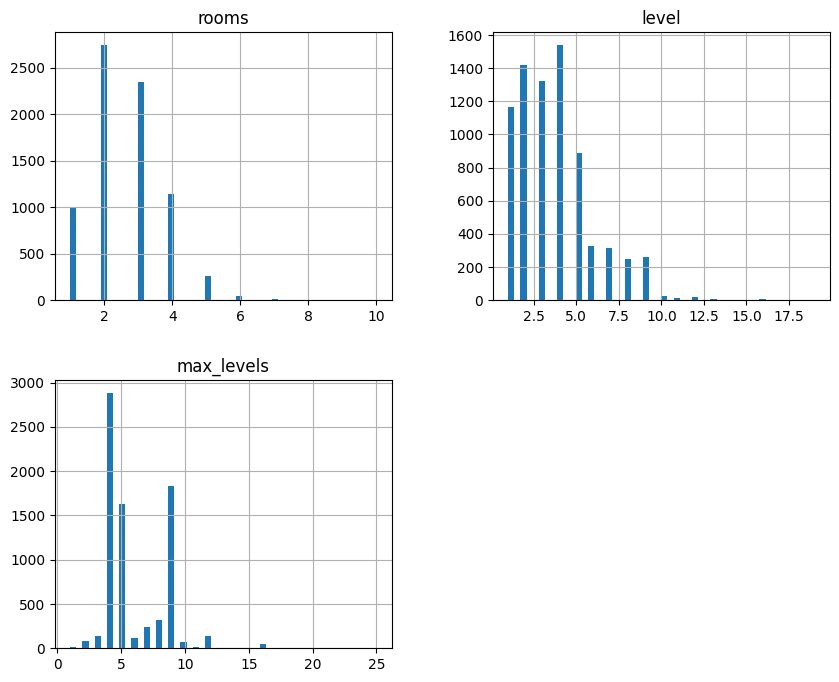

In [169]:
df.hist(bins=50, figsize=(10,8))
plt.show()

# **`Train and Test sets`**

In [170]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

# **`Data Preparation with Sklearn`**

In [171]:
from sklearn.base import BaseEstimator, TransformerMixin
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X['remaining_levels'] = X['max_levels'] - X['level']
        return X

In [172]:
class FilterSize(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    if not pd.api.types.is_float_dtype(X['size']):
      X['size'] = X['size'].replace('Площадьземли:1сот', '100')
      X['size'] = pd.to_numeric(X['size'], errors='coerce')
      X = X[X['size'] <= 7000] #we removed over 7000 because of effect for the model (a few data)
    return X

In [173]:
class FilterPrice(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    if not pd.api.types.is_integer_dtype(X['price']):
      X = X[X['price'] != 'Договорная']
      X['price'] = X['price'].astype(int)
      X = X[X['price'] <= 800000] #we removed over 800000 because of effect for the model (a few data)
    return X

# **`Pipeline`**

In [174]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [175]:
# general data
general_pipeline = Pipeline([
          ('price_filter', FilterPrice()),
          ('size_filter', FilterSize())
])

In [176]:
# numerical data
num_pipeline = Pipeline([
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

In [196]:
def filterData(data):
  data = general_pipeline.fit_transform(data)
  housing = data.drop("price", axis=1)
  housing_labels = data["price"].copy()
  housing_num = housing.drop("district", axis=1)

  num_attribs = list(housing_num)
  cat_attribs = ['district']

  full_pipeline = ColumnTransformer([
        ('num', num_pipeline, num_attribs),
        ('cat', OneHotEncoder(), cat_attribs)
    ])

  return full_pipeline.fit_transform(housing), housing_labels


In [178]:
filterData(train_set)[0]

<ipython-input-173-ba7a05d8ce5c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['price'] = X['price'].astype(int)


array([-0.57421446, -0.46796496, -0.31179628, -0.78520541, -0.60336934,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ])

In [197]:
X_train, y_train = filterData(train_set)


<ipython-input-173-ba7a05d8ce5c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['price'] = X['price'].astype(int)


# **`Linear Regression Model`**

In [201]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
LR_model=LinearRegression()
LR_model.fit(X_train,y_train)


LinearRegression()

**`Model Evaluation`**

In [202]:
X_test, y_test = filterData(test_set)
y_predicted=LR_model.predict(X_test)

<ipython-input-173-ba7a05d8ce5c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['price'] = X['price'].astype(int)


In [203]:
from sklearn.metrics import mean_squared_error
mse=mean_squared_error(y_test,y_predicted)
rmse=np.sqrt(mse)
print("RMSE: ",rmse)

RMSE:  38295.73745519765


# **`Decision Tree`**

In [207]:
from sklearn.tree import DecisionTreeRegressor
Tree_model=DecisionTreeRegressor()
Tree_model.fit(X_train,y_train)

DecisionTreeRegressor()

In [208]:
y_predicted=Tree_model.predict(X_test)

**`Model Evaluation`**

In [209]:
mse=mean_squared_error(y_test,y_predicted)
rmse=np.sqrt(mse)
print("RMSE: ",rmse)

RMSE:  35850.82559051178


# **`RandomForest`**

In [210]:
from sklearn.ensemble import RandomForestRegressor
RF_model=RandomForestRegressor()
RF_model.fit(X_train,y_train)

RandomForestRegressor()

In [211]:
y_predicted=RF_model.predict(X_test)

**`Model Evaluation`**

In [212]:
mse=mean_squared_error(y_test,y_predicted)
rmse=np.sqrt(mse)
print("RMSE: ",rmse)

RMSE:  31812.865263260548


***`As we can see we got the best model using the RandomForest algorithm`***



In [213]:
import joblib

filename = 'Forest_model.jbl'
joblib.dump(RF_model, filename) # save the model

['Forest_model.jbl']